<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Final-Project-Submission-Capstone-Project" data-toc-modified-id="Final-Project-Submission-Capstone-Project-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Final Project Submission Capstone Project</a></span><ul class="toc-item"><li><span><a href="#Summary:" data-toc-modified-id="Summary:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Summary:</a></span></li></ul></li><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Choose-Zip-Codes-by-Percent-Increase-in-Median-Price" data-toc-modified-id="Choose-Zip-Codes-by-Percent-Increase-in-Median-Price-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Choose Zip Codes by Percent Increase in Median Price</a></span><ul class="toc-item"><li><span><a href="#Create-Melted-Dataframe-of-ZipCodes" data-toc-modified-id="Create-Melted-Dataframe-of-ZipCodes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create Melted Dataframe of ZipCodes</a></span></li></ul></li><li><span><a href="#Forecast" data-toc-modified-id="Forecast-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Forecast</a></span><ul class="toc-item"><li><span><a href="#Replace-Null-Values-with-0" data-toc-modified-id="Replace-Null-Values-with-0-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Replace Null Values with 0</a></span></li><li><span><a href="#Use-model-to-create-prediction-for-each-stock" data-toc-modified-id="Use-model-to-create-prediction-for-each-stock-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Use model to create prediction for each stock</a></span></li><li><span><a href="#Create-preds-df-that-can-be-added-to-submission" data-toc-modified-id="Create-preds-df-that-can-be-added-to-submission-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Create preds df that can be added to submission</a></span><ul class="toc-item"><li><span><a href="#Ready-to-add-to-submission" data-toc-modified-id="Ready-to-add-to-submission-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Ready to add to submission</a></span></li></ul></li></ul></li><li><span><a href="#Iterate-Forecast-for-each-stock" data-toc-modified-id="Iterate-Forecast-for-each-stock-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Iterate Forecast for each stock</a></span><ul class="toc-item"><li><span><a href="#Create-one-ARIMA-model" data-toc-modified-id="Create-one-ARIMA-model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Create one ARIMA model</a></span></li></ul></li></ul></div>

# Final Project Submission Capstone Project
* Student name: Jim Petoskey
* Student pace: Self-paced
* Scheduled project review date/time: ________
* Instructor name: Abhineet Kulkarni
* [Blog post URL: Time Series Decomposition - Spotting Seasonality](______)
* [Time Series Zillow Starter Repository](_____)

## Summary:


# Import Libraries

In [18]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('default')
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as mtick

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Functions

## Min Max Scaler

In [19]:
def min_max(df):
    # MinMax Scale columns (-1, 1 scale)   
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(df)
    train_cols = df.columns.values.tolist()
    trained = pd.DataFrame(data=scaled, columns=train_cols, index=df.index)
    return trained

## Fill NaN

In [20]:
def fill_nan(df):
    df = df.sort_values(["SecuritiesCode","Date"], ascending=[True,True])
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df = df.sort_values(["Date","SecuritiesCode"], ascending=[True,True])
    return df

## Plot

In [21]:
def plot(predictions, y_test):
    
    # df with Predictions and Target
    date_df = pd.DataFrame()
    date_df['Predictions'] = predictions
    date_df['Target'] = y_test

    sns.set(rc={'figure.figsize':(11.7,8.27)})

    sns.set_theme(style="white", palette='bright', font_scale=2)

    ax = sns.lineplot(data=date_df, 
                          palette="bright", 
                          markers=False, 
                          dashes=False).set(title='Sharpe Ratio Predictions', 
                                            xlabel="Trading Days",
                                            ylabel= "Sharpe Ratio (norm.)"
                                            )
    sns.despine()

    x = plt.show()
    
    return x

## Kaggle Scoring

In [22]:
def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

# Create Prices df

In [23]:
# Create dataframe from zillow median home price data
df = pd.read_csv("gs://cloud-ai-platform-b875a61a-655c-477f-8e45-4ada5ba4908b/stock_prices.csv")
#stock_list_df = pd.read_csv(r'/Users/jimpetoskey/Documents/Flatiron/phase5/data/stock_list.csv')

In [24]:
# make copy of df
df1 = df.copy()

df1

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


## Set Datetime Index

In [26]:
# Set Datetime index
df1['Date'] = pd.to_datetime(df1['Date'], format='%Y/%m/%d', errors='coerce')
mask = df1['Date'].isnull()
df1.loc[mask, 'Date'] = pd.to_datetime(df1['Date'], format='%Y/%m/%d',
                                            errors='coerce')
df1 = df1.set_index(['Date'])
df1

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,20211203_9990,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2021-12-03,20211203_9991,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2021-12-03,20211203_9993,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302


## Min Max Target

In [27]:
# Min_max scale target
df2 = df1['Target']
df2 = pd.DataFrame(df2)
df2 = min_max(df2)

# Add securities codes back into df for id
df2['SecuritiesCode'] = df1['SecuritiesCode']

df2

,Target,SecuritiesCode
Date,,
2017-01-04,-0.317723,1301
2017-01-04,-0.304068,1332
2017-01-04,-0.311335,1333
2017-01-04,-0.305564,1376
2017-01-04,-0.315019,1377
...,...,...
2021-12-03,-0.277576,9990
2021-12-03,-0.288575,9991
2021-12-03,-0.323650,9993


## Model One Stock

In [28]:
# Pull all stock values for given stock from stock_prices
values1301 = df2.loc[df2['SecuritiesCode'] == 1301]
values1301

,Target,SecuritiesCode
Date,,
2017-01-04,-0.317723,1301
2017-01-05,-0.315144,1301
2017-01-06,-0.319869,1301
2017-01-10,-0.324590,1301
2017-01-11,-0.322464,1301
...,...,...
2021-11-29,-0.314115,1301
2021-11-30,-0.309681,1301
2021-12-01,-0.298906,1301


In [29]:
# create new df with datetime index and Target row only
#df_ind = df.set_index(['A', 'B'])
values1301_copy = values1301.copy()
values1301_copy = values1301_copy.iloc[:, [0]]
values1301_copy

,Target
Date,
2017-01-04,-0.317723
2017-01-05,-0.315144
2017-01-06,-0.319869
2017-01-10,-0.324590
2017-01-11,-0.322464
...,...
2021-11-29,-0.314115
2021-11-30,-0.309681
2021-12-01,-0.298906


## Without Walk-Forward Validation

Test RMSE: 0.017


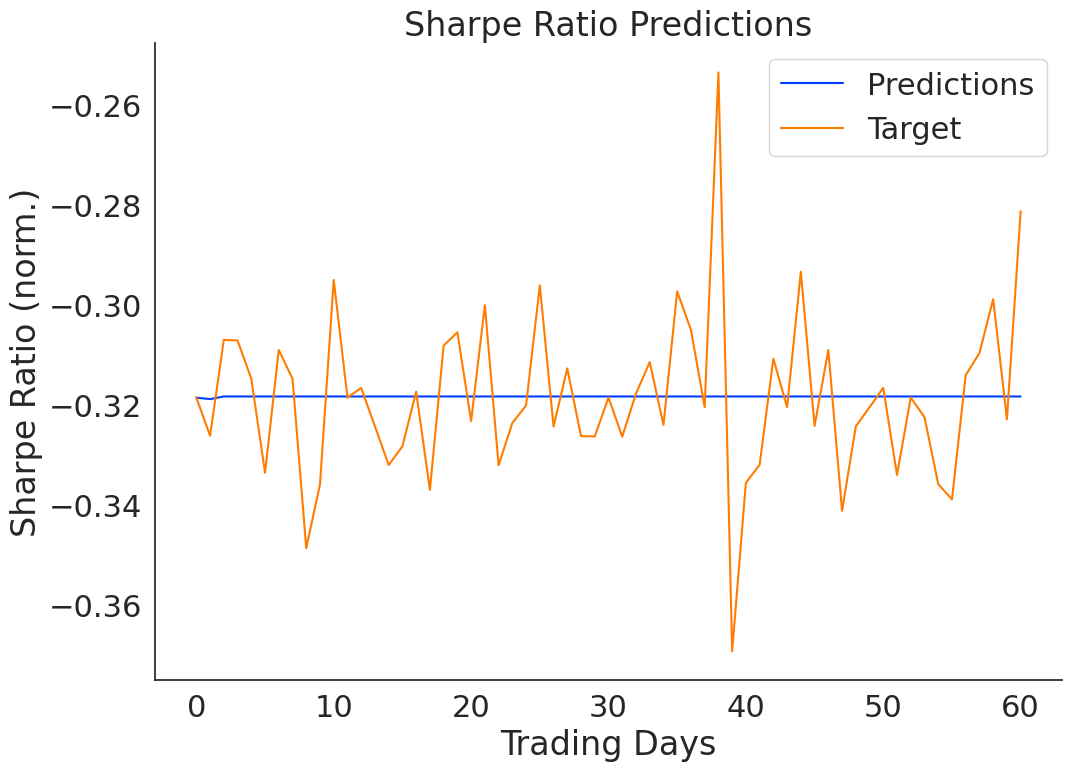

In [30]:
# evaluate an ARIMA model without a walk-forward validation

series = values1301_copy
#series.index = series.index.to_period('M')

# split into train and test sets
X = series.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

model = ARIMA(train, order=(0,0,2))
model.initialize_approximate_diffuse()
model_fit = model.fit()
output = model_fit.forecast(steps=61)
pred = pd.DataFrame(output)
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, pred))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plot(pred, test)

## With Walk-Forward Validation

RMSE:  0.01695146422207456


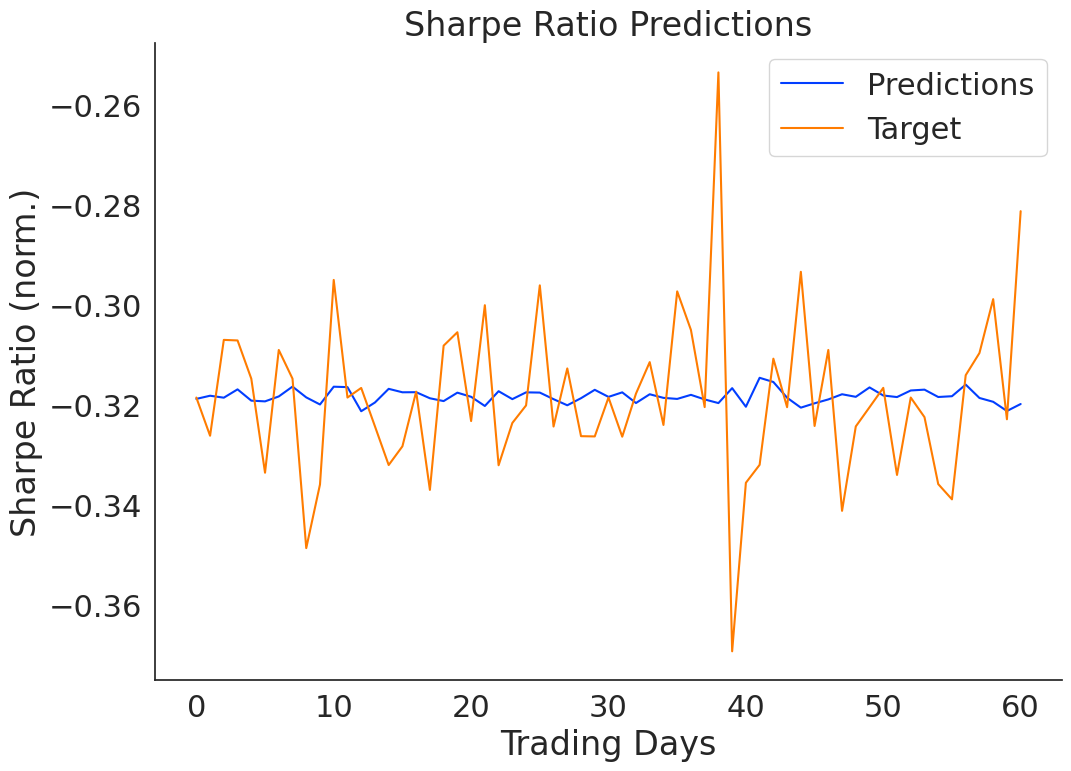

In [36]:
series = values1301_copy

# split into train and test sets
X = series.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(4,0,4))
    model.initialize_approximate_diffuse()
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: ', rmse)

# Plot Predictions and Target
plot(predictions, test)

## Summary:
* While this model has a relatively low RMSE, this is accomplished by always guessing the mean.
* This method/model is not likely to differentiate between stocks very well.
* The walk-forward validation model varies more from the mean, but it is computationally expensive and won't be valid for making a prediction for each stock.

# Model 5 Stocks

In [32]:
# Use df2 and reset index to bring date in as column in df
df3 = df2.reset_index(drop=False)

# Pivot table to include only Target based on SecuritiesCode
df3 = df3.pivot(index='Date', columns='SecuritiesCode', values='Target')

df3

SecuritiesCode,1301,1332,1333,1375,1376,1377,1379,1381,1407,1413,...,9982,9983,9984,9987,9989,9990,9991,9993,9994,9997
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,-0.317723,-0.304068,-0.311335,NaN,-0.305564,-0.315019,-0.312495,-0.329568,-0.322631,NaN,...,-0.298319,-0.397952,-0.288245,-0.317075,-0.283941,-0.344633,-0.318583,-0.300866,-0.319916,-0.309771
2017-01-05,-0.315144,-0.345212,-0.331190,NaN,-0.312523,-0.313253,-0.329045,-0.295174,-0.329190,NaN,...,-0.323563,-0.349126,-0.310133,-0.335151,-0.305963,-0.340465,-0.298726,-0.288200,-0.328593,-0.324414
2017-01-06,-0.319869,-0.337445,-0.336787,NaN,-0.318583,-0.357490,-0.324694,-0.327643,-0.341584,NaN,...,-0.318583,-0.322540,-0.308515,-0.309417,-0.304710,-0.333124,-0.312416,-0.338119,-0.318583,-0.325908
2017-01-10,-0.324590,-0.337752,-0.320432,NaN,-0.350233,-0.263716,-0.326960,-0.318583,-0.313009,NaN,...,-0.318583,-0.335383,-0.327595,-0.353448,-0.359717,-0.341158,-0.323695,-0.322428,-0.336755,-0.352488
2017-01-11,-0.322464,-0.299097,-0.300064,NaN,-0.305419,-0.330815,-0.328145,-0.317366,-0.318583,NaN,...,-0.311081,-0.305568,-0.312016,-0.315459,-0.291588,-0.325588,-0.315502,-0.318583,-0.309696,-0.307958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,-0.314115,-0.316527,-0.307203,-0.305034,-0.314214,-0.314814,-0.288530,-0.299798,-0.365336,-0.315802,...,-0.296281,-0.324175,-0.343975,-0.316674,-0.339074,-0.314053,-0.315516,-0.324893,-0.312512,-0.286798
2021-11-30,-0.309681,-0.320635,-0.316534,-0.336762,-0.341217,-0.327975,-0.332300,-0.331526,-0.359778,-0.324686,...,-0.347310,-0.317529,-0.378672,-0.312865,-0.314573,-0.352428,-0.306346,-0.333385,-0.307509,-0.320302
2021-12-01,-0.298906,-0.293917,-0.290454,-0.296232,-0.314145,-0.295860,-0.303442,-0.299887,-0.295298,-0.271180,...,-0.272311,-0.327179,-0.326997,-0.292030,-0.291406,-0.269797,-0.294360,-0.322152,-0.305119,-0.297919


In [33]:
rand_stocks = [7596, 4998, 5802, 9663, 4464]
rand_stocks

[7596, 4998, 5802, 9663, 4464]

In [34]:
# Create df with rand_stock list
rand_df = df3[rand_stocks]

Test RMSE: 0.016


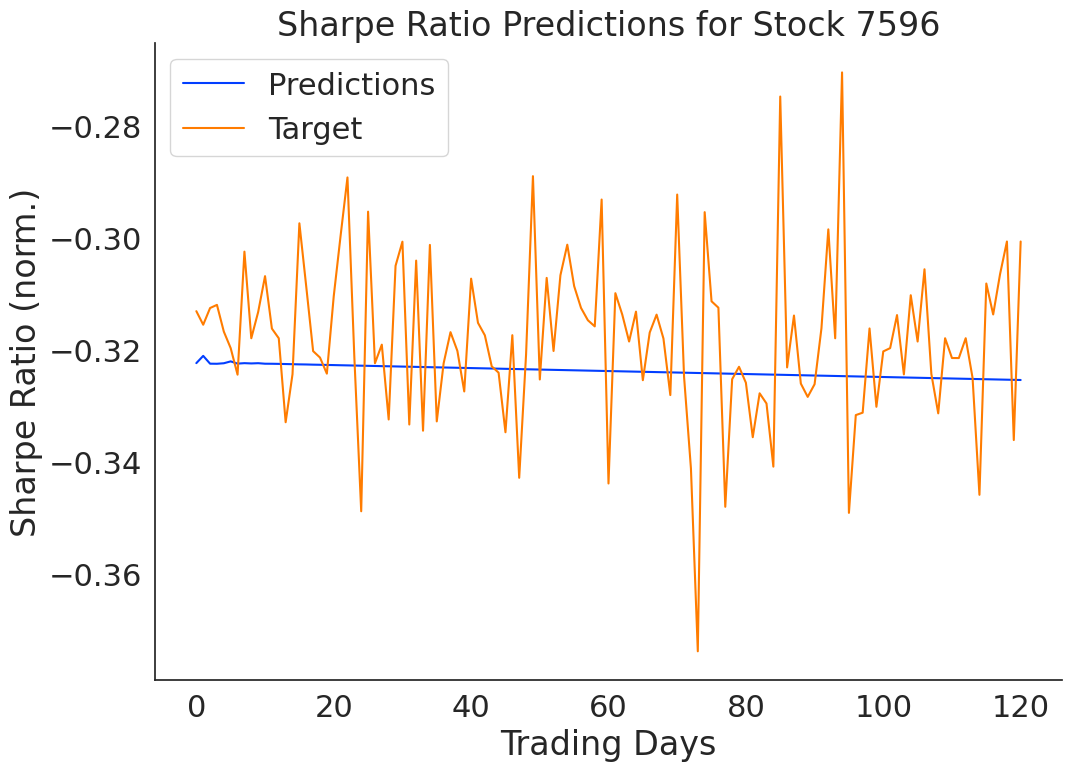

Test RMSE: 0.013


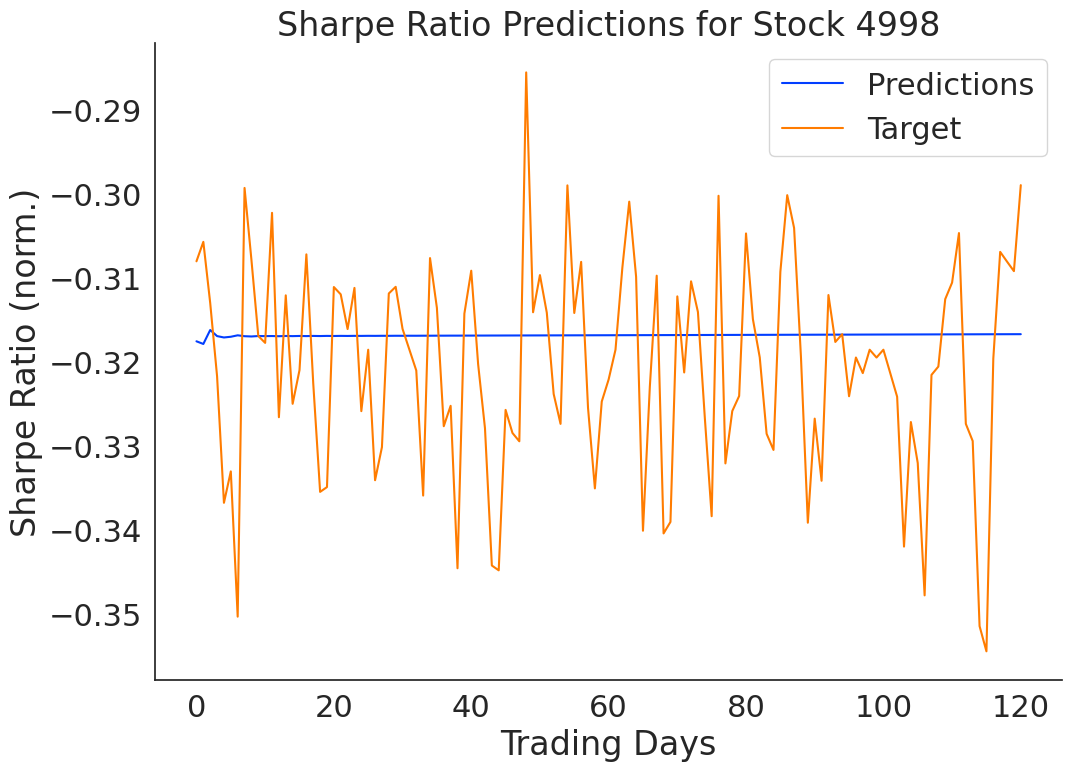

Test RMSE: 0.026


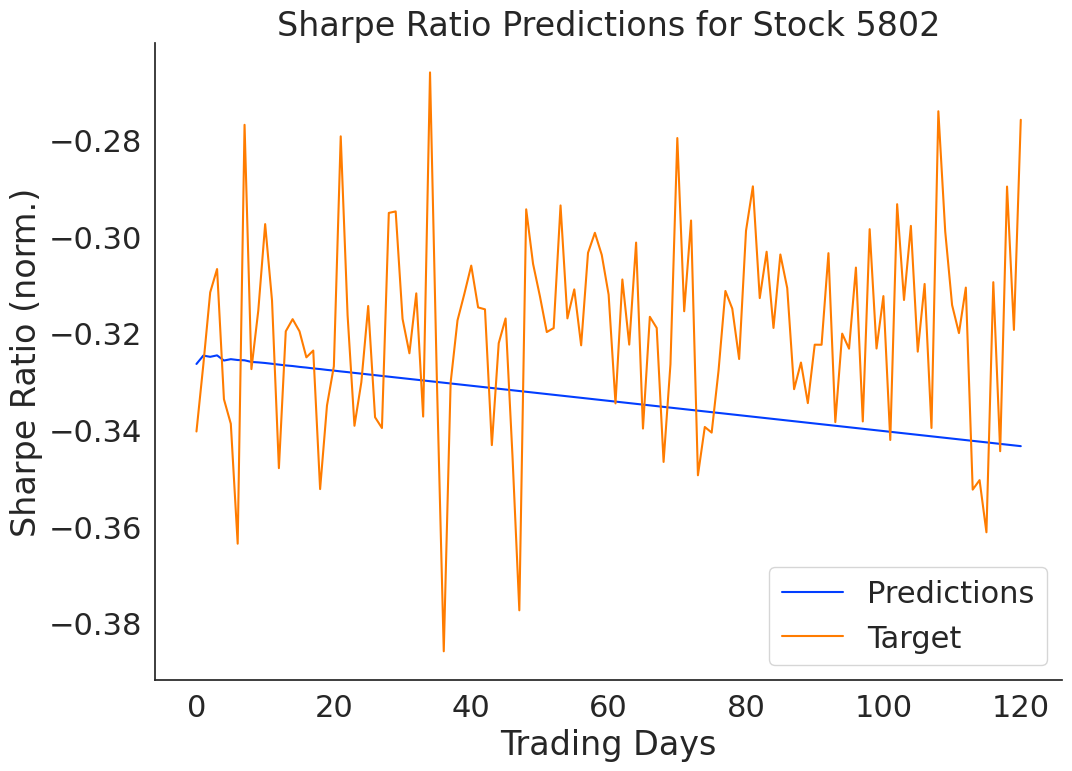

Test RMSE: 0.028


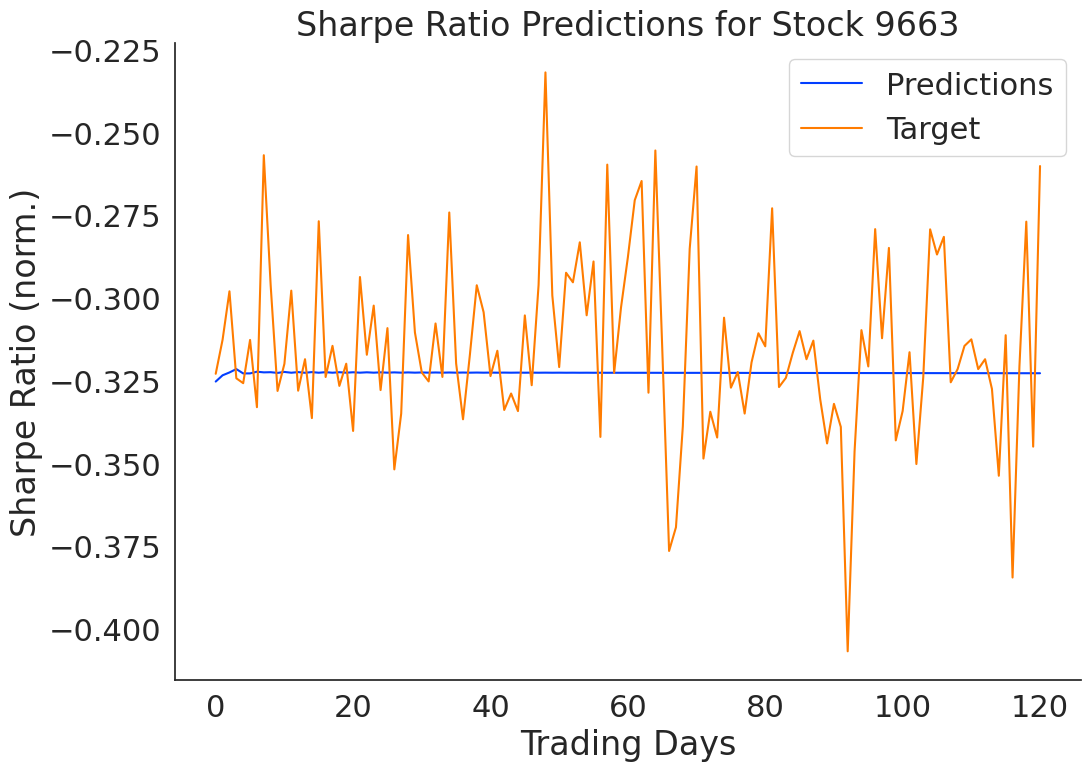

Test RMSE: 0.019


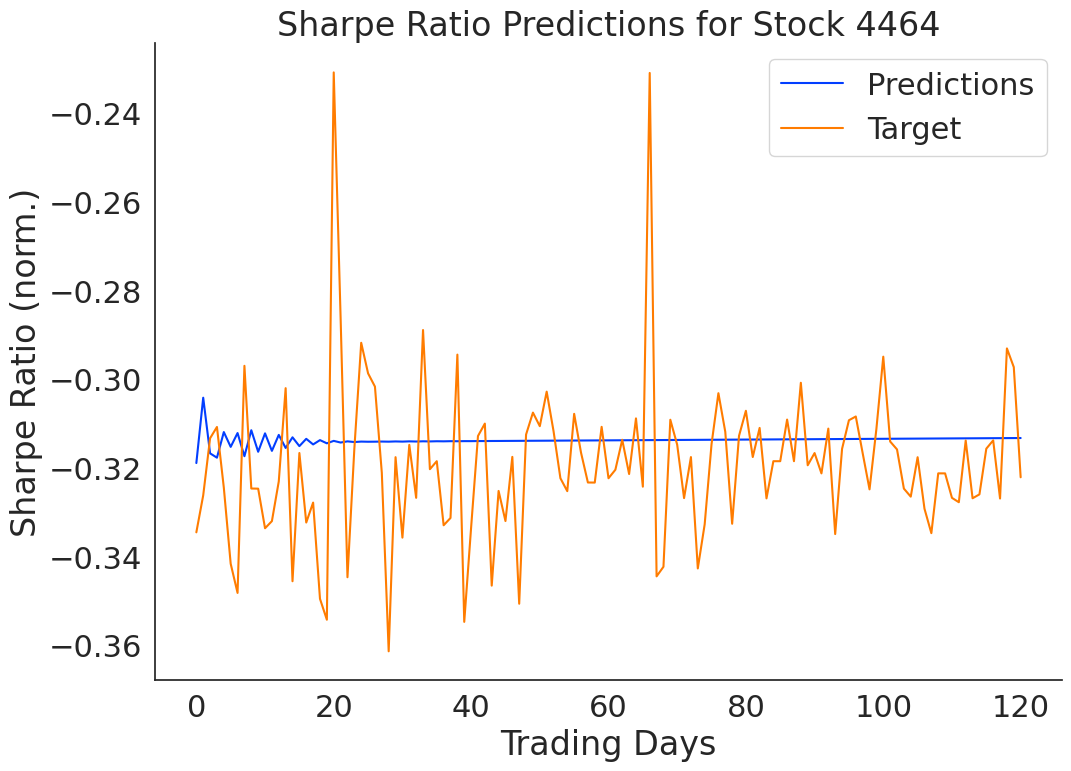

In [35]:
# Create RMSE List
RMSE_ARIMA = {}

preds_df = pd.DataFrame()

for code in rand_stocks:
    df = rand_df[code]
    df = pd.DataFrame(df)
    
    # split into train and test sets
    X = rand_df[code].values
    size = int(len(X) * 0.9)
    train, test = X[0:size], X[size:len(X)]
    
    # Model stock 
    model = ARIMA(train, order=(4,2,2))
    model.initialize_approximate_diffuse()
    model_fit = model.fit()
    output = model_fit.forecast(steps=121)
    pred = pd.DataFrame(output)

    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, output))
    
    # Store and print RMSE
    RMSE_ARIMA[code] = [rmse]
    print('Test RMSE: %.3f' % rmse)
    
    # df with Predictions and Target
    date_df = pd.DataFrame()
    date_df['Predictions'] = pred
    date_df['Target'] = test

    sns.set(rc={'figure.figsize':(11.7,8.27)})

    sns.set_theme(style="white", palette='bright', font_scale=2)

    ax = sns.lineplot(data=date_df, 
                          palette="bright", 
                          markers=False, 
                          dashes=False).set(title='Sharpe Ratio Predictions for Stock '+str(code), 
                                            xlabel="Trading Days",
                                            ylabel= "Sharpe Ratio (norm.)"
                                            )
    sns.despine()

    plt.show()

# Forecast All Stocks, Modeled Individually

In [ ]:
df3

## Create Scoring df

In [ ]:
# Cut out last date as df_test
df_test = df3.loc['2021-12-03']
df_test = pd.DataFrame(df_test)
df_test['Target'] = df_test['2021-12-03']
df_test = df_test.iloc[: , 1:]
df_test = df_test.reset_index()
df_test

### Drop Scoring df from train

In [ ]:
df4 = df3.iloc[0:1201]
df4

## Forecast

In [ ]:
# Create empty preds df and sec code list
full_preds = pd.DataFrame()
full_col_list = df4.columns.to_list()

# Iterate over each stock to model
for i in full_col_list:
    df = df4[i]
    model = ARIMA(df, order=(4,2,4))
    model.initialize_approximate_diffuse()
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    pred = pd.DataFrame(output)
    pred[i] = pred[0]
    pred = pred.drop(0, axis=1)
    full_preds = pd.concat([pred,full_preds], axis=1)
full_preds

# Format full_preds for submission
    # pivot preds
preds_pivot = full_preds.reset_index(drop=True)
preds_pivot = preds_pivot.loc[0]
preds_pivot_df = pd.DataFrame(preds_pivot)
preds_pivot_df = preds_pivot_df.rename_axis('SecuritiesCode').reset_index()
preds_pivot_df['Target'] = preds_pivot_df[0]
preds_pivot_df = preds_pivot_df.drop(0, axis=1)

preds_pivot_df['Rank'] = preds_pivot_df["Target"].rank(method="first",ascending=False)-1
rank = preds_pivot_df.set_index('SecuritiesCode')['Rank'].astype('int').to_dict()

# submission["Rank"] = submission['SecuritiesCode'].map(rank)
# env.predict(submission)
preds_pivot_df

In [ ]:
preds_pivot_df

# Score Model

## Predictions df

In [ ]:
# Pull predictions from preds_df and arrange them for scoring
#pred_practice = preds_df.loc[0]
#d = {'Target': pred_practice}
#pred_practice_df = pd.DataFrame(d)
#pred_practice_df = pred_practice_df.rename_axis('SecuritiesCode').reset_index()

# Generate df with actual ranks and predicted ranks
#test_set_targets = test_set_target.sort_values(by = ['Target'], ascending = False)
#test_set_targets['Actual_Rank'] = np.arange(len(pred_practice_df.index))

# Rank by Target values
pred_practice_df = preds_pivot_df.sort_values(by = ['Target'], ascending = False)
pred_practice_df['Rank'] = np.arange(len(pred_practice_df.index))

# Drop Target column
pred_practice_df = pred_practice_df.drop(["Target"], axis = 1)

# Merge results with actual target values from original test set
result = pd.merge(df_test, pred_practice_df, on="SecuritiesCode")
result = result.sort_values(by = ['Rank'], ascending = True)
result

## Score

In [116]:
z = _calc_spread_return_per_day(result, 200, 2)
z

-1.4357484933441214

# Summary:
* The ARIMA models do not produce forecasts necessary to differentiate between stocks.
* Even when each stock is modelled individually, ARIMA is not able to differentiate between the Sharpe Ratio value.